In [1]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns
from ipywidgets import interact, interact_manual
import numpy as np
import json

# Read in

In [44]:
dta = pd.read_csv('Base_PNMfusion.csv', encoding='latin1')
dta['Pays_origine'] = dta['Secteur Origine'].apply(lambda r: r if r in ('France', 'Allemagne', 'Belgique') else 'Luxembourg')
dta['Pays_dest'] = dta['Secteur Destination'].apply(lambda r: r if r in ('France', 'Allemagne', 'Belgique') else 'Luxembourg')

In [45]:
zones = pd.read_json('../zones/zones.json')

In [46]:
for key in ('origine', 'dest'):
    dta = (
        dta
        .merge(zones[['corridor', 'country', 'index']], 
               left_on=[f'Corridor_PNM_{key}', f'Pays_{key}'], 
               right_on=['corridor', 'country'],
               how='left')
        .drop(['corridor', 'country'], axis=1)
        .rename(columns={'index': f'corridor_{key}'})
    )

So it seems there still are flows leading to undefined zones - let's drop those:

In [66]:
print(f'with NaN zones: {len(dta)}')
dta = dta.dropna(subset=['corridor_origine', 'corridor_dest'], how='any')
for key in ('corridor_dest', 'corridor_origine'):
    dta[key] = dta[key].astype(int)
print(f'without NaN zones: {len(dta)}')

with NaN zones: 31249
without NaN zones: 31249


# Aggregate by corridors

In [113]:
flows = (dta.groupby(['corridor_origine', 'corridor_dest', 'Mode'])
         .agg({'flux 2017': 'sum',
               'Flux_2035_nouvelle_cible': 'sum'})
         .rename(columns={'flux 2017': 'flux_2017', 'Flux_2035_nouvelle_cible': 'flux_2035'})
         .round(0)
         .reset_index()
        )

<AxesSubplot: xlabel='corridor_dest', ylabel='corridor_origine'>

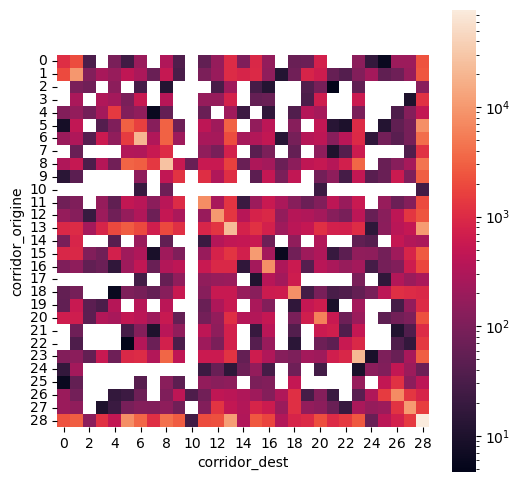

In [114]:
plt.figure(figsize=(6, 6))
sns.heatmap(flows.pivot_table(index=['corridor_origine'], columns=['corridor_dest'], values='flux_2017'), norm=LogNorm(), square=True)

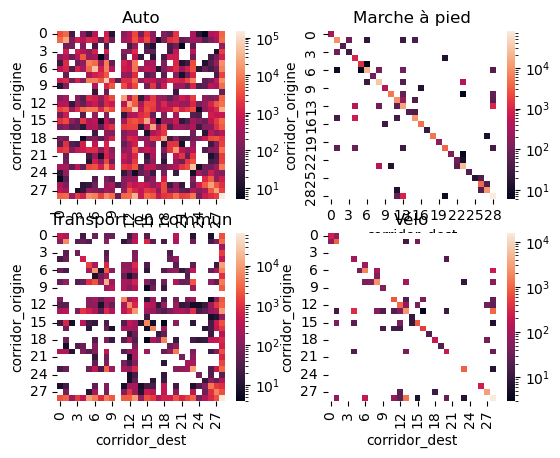

In [115]:
for i, mode in enumerate(flows.reset_index().Mode.unique()):
    plt.subplot(2, 2, i+1)
    plt.title(mode)
    sns.heatmap(flows.reset_index().query('Mode==@mode').pivot_table(index=['corridor_origine'], columns=['corridor_dest'], values='flux_2017'), norm=LogNorm(), square=True)


In [170]:
flows['mode'], mode_keys = pd.factorize(flows.reset_index()['Mode'])
for i, key in enumerate(mode_keys):
    print(f' {i}: {key}')

 0: Auto
 1: Marche à pied
 2: Transport en commun
 3: Vélo


Index(['Auto', 'Marche à pied', 'Transport en commun', 'Vélo'], dtype='object')

In [153]:
temp = {}
nzones = len(zones)
for mode, f17, f35, orig, dest in flows.reset_index()[['mode', 'flux_2017', 'flux_2035', 'corridor_origine', 'corridor_dest']].itertuples(index=None):
    temp[('c', orig, mode, dest)] = int(f17)
    temp[('p', orig, mode, dest)] = int(f35)

def get_flows_for_dest(scenario, orig, mode):
    return [temp.get((scenario, orig, mode, dest), 0) for dest in range(nzones)]
    
flat = [[[get_flows_for_dest(scenario, orig, mode) for mode in range(len(mode_keys))] for orig in range(nzones)] for scenario in ('c', 'p')]
                
with open('flows.json', 'w') as f:
    json.dump(flat, f)

A quick sanity check:

In [157]:
flows.sum()

corridor_origine                                                21695
corridor_dest                                                   21652
Mode                AutoMarche à piedTransport en communVéloAutoTr...
flux_2017                                                   2021058.0
flux_2035                                                   2817946.0
mode                                                             1952
dtype: object

In [162]:
[sum(sum(mode) for origin in scenario for mode in origin) for scenario in flat]

[2021058, 2817946]

In [166]:
flows.query('Mode=="Transport en commun" & (corridor_origine==0)')

,corridor_origine,corridor_dest,Mode,flux_2017,flux_2035,mode
2,0,0,Transport en commun,438.0,834.0,2
5,0,1,Transport en commun,268.0,649.0,2
9,0,4,Transport en commun,22.0,89.0,2
12,0,6,Transport en commun,57.0,113.0,2
15,0,8,Transport en commun,53.0,246.0,2
18,0,9,Transport en commun,56.0,101.0,2
20,0,11,Transport en commun,0.0,5.0,2
23,0,12,Transport en commun,21.0,86.0,2
26,0,13,Transport en commun,244.0,705.0,2
30,0,15,Transport en commun,34.0,68.0,2


In [178]:
flat[1][0][2]

[834,
 649,
 0,
 0,
 89,
 0,
 113,
 0,
 246,
 101,
 0,
 5,
 86,
 705,
 0,
 68,
 0,
 0,
 25,
 0,
 597,
 0,
 0,
 150,
 0,
 0,
 13,
 27,
 3938]